In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pyart
import wsrlib
from wsrlib import *


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Helper function
def image2xy(x, y, r=0, dim=600, rmax=150000):
    '''
    Convert from image coordinates to (x,y) coordinates offset from radar
    '''
    
    x0 = y0 = dim/2.0 # origin
    x =  (x - x0)*2*rmax/dim
    y = -(y - y0)*2*rmax/dim
    r = r*2*rmax/dim
    
    return x, y, r

In [3]:
name = 'KBUF20160826_103825_V06'
x0, y0, r = image2xy(64.915009,390.60,52.056629) # roost coordinates
radar = wsrlib.read_s3(name)

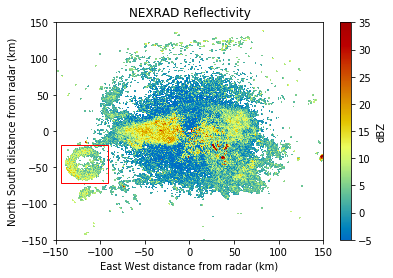

In [4]:
# Plot reflectivity
disp = pyart.graph.RadarDisplay(radar)
rmax = 150 # km
lim = (-rmax, rmax)
disp.plot('reflectivity', 0, 
          title='NEXRAD Reflectivity',
          vmin=-5, 
          vmax=35, 
          colorbar_label='dBZ')

disp.set_limits(xlim=lim, ylim=lim)

# Plot roost
rect = patches.Rectangle(((x0-r)/1000,(y0-r)/1000),
                         2*r/1000,
                         2*r/1000,
                         linewidth=1,
                         edgecolor='r',
                         facecolor='none')
plt.gca().add_patch(rect)
plt.show()

# See cross sections of a roost at different elevations

[0.48339844 1.3183594  2.4169922  3.1201172  3.9990234 ]


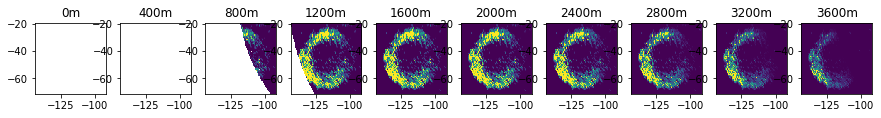

In [7]:
# Get radar data on standardized polar grid
#  --- all sweeps have same range, az values
data, fields, elev, rng, az = radar2mat(radar, 
                                        coords='polar', 
                                        elevs=[0.5, 1.5, 2.5, 3.5, 4.5]);

print(elev)

# Convert to reflectivity on linear scale and set nans to zero
refl, _ = z_to_refl(idb(data[0]))
refl[np.isnan(refl)] = 0.

# The interpolating function
F = radarVolumeInterpolant(refl, elev, rng, az, method='linear', elev_buffer=0.5)

# Define grid
n_levels = 11
grid = Grid([
    (x0-r, x0+r, 100),   # arguments to np.linspace for x dimension
    (y0-r, y0+r, 100),   # y dimension 
    (0, 4000,  n_levels) # z dimension   
])

# Get radar coordinates of grid points
x, y, z = grid.points()
elev, rng, az = xyz2radar(x, y, z)

# Do interpolation
grid_val = F((elev, rng, az))

# Show results
x, y, height = grid.coords()

fig, ax = plt.subplots(ncols=10, figsize=(15,3))

vmin, vmax = 0, 300
for i in range(10):
    im = ax[i].imshow(grid_val[:,:,i], 
                      extent = (x[0]/1000, x[-1]/1000, y[0]/1000, y[-1]/1000),
                      origin='lower', vmin=vmin, vmax=vmax)
    ax[i].set_title(f"{height[i]:.0f}m")
    
plt.show()

# See vertical section along azimuth

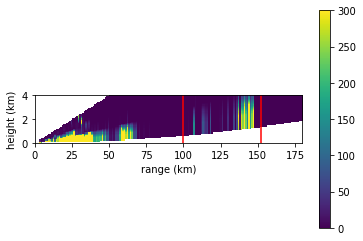

In [14]:
# Get azimuth of roost center
elev, roost_rng, az = xyz2radar(x0, y0, 0)

# Define a range, height, az grid
grid = Grid([
    (0, 180000, 181),   # 0 to 150km
    (0, 4000,   41),    # 0 to 4km
])

# Get slant range and elevation angle
rng, height = grid.points()
slant_rng, elev = ground2slant(rng, height)

# Pass coordinates to interpolating function
section = F((elev, slant_rng, az))

# Plot results
plt.figure(figsize=(14, 3))
plt.imshow(section, extent=(0, 180, 0, 4), aspect=8.0, origin='lower', vmin=0, vmax=300)
plt.xlabel('range (km)')
plt.ylabel('height (km)')
plt.axvline((roost_rng + r)/1000, color='red')
plt.axvline((roost_rng - r)/1000, color='red')
plt.colorbar()